## Read CSV files

In [13]:
import pandas as pd
from collections import namedtuple

## read crystal- and dco- timestamped data
columns = ['Timestamp', 'X', 'Y', 'Z'];

# Store data into named tuple
LimbData = namedtuple("LimbData", "Crystal DCO");

# Get left pocket (LP) data
crystal_df_rp = pd.read_csv('Data/Crystal_accel_COM10_4MHz_1.csv', names=columns);
crystal_rp = crystal_df_rp.as_matrix();
dco_df_rp = pd.read_csv('Data/DCO_accel_COM10_2MHz_1.csv', names=columns);
dco_rp = dco_df_rp.as_matrix();
RP = LimbData(crystal_rp, dco_rp);

# Get right pocket (RP) data
crystal_df_lp = pd.read_csv('Data/Crystal_accel_COM12_4MHz_1.csv', names=columns);
crystal_lp = crystal_df_lp.as_matrix();
dco_df_lp = pd.read_csv('Data/DCO_accel_COM12_2MHz_1.csv', names=columns);
dco_lp = dco_df_lp.as_matrix();
LP = LimbData(crystal_lp, dco_lp);

## Filters

In [4]:
from scipy import signal
# Quick define a high pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


## Plt Data

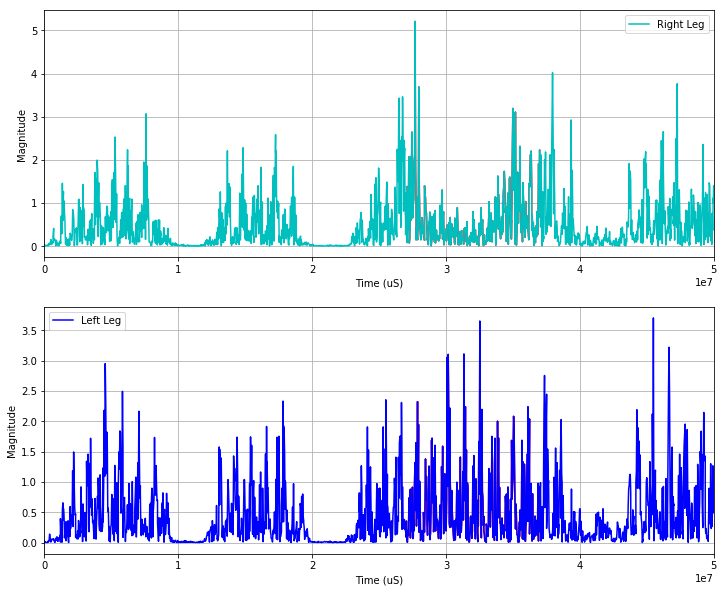

In [105]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import mpld3
mpld3.enable_notebook();

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

freq = 50
cutoff = 5

# Get magnitude of LP and RP
RPTime = RP.Crystal[:,0];
RPTime = RPTime - RPTime[0];
RPMag = np.square(RP.Crystal[:,1]) + np.square(RP.Crystal[:,2]) + np.square(RP.Crystal[:,3]);
RPMag = np.sqrt(RPMag);
RPMag = butter_highpass_filter(RPMag, cutoff, freq);

LPTime = LP.Crystal[:,0];
LPTime = LPTime - LPTime[0];
LPMag = np.square(LP.Crystal[:,1]) + np.square(LP.Crystal[:,2]) + np.square(LP.Crystal[:,3]);
LPMag = np.sqrt(LPMag);
LPMag = butter_highpass_filter(LPMag, cutoff, freq);

fig, (ax1, ax2) = plt.subplots(nrows=2);
frame = plt.gca()

hp_rp = np.where((RPTime > 27000000) & (RPTime < 37000000));
hp_lp = np.where((LPTime > 27000000) & (LPTime < 37000000));

ax1.plot(RPTime[hp_rp], abs(RPMag[hp_rp]), 'r');
ax1.plot(RPTime, abs(RPMag), 'c', label="Right Leg");

ax1.set_xlim([0, 50000000])
ax1.legend();
ax1.set_xlabel("Time (uS)")
ax1.set_ylabel("Magnitude");
ax1.grid();

ax2.plot(LPTime[hp_lp], abs(LPMag[hp_lp]), 'r');
ax2.plot(LPTime, abs(LPMag), 'b', label="Left Leg");
ax2.set_xlim([0, 50000000])
ax2.legend();
ax2.set_xlabel("Time (uS)")
ax2.set_ylabel("Magnitude");
ax2.grid();
plt.show();

## Check out some cross correlations

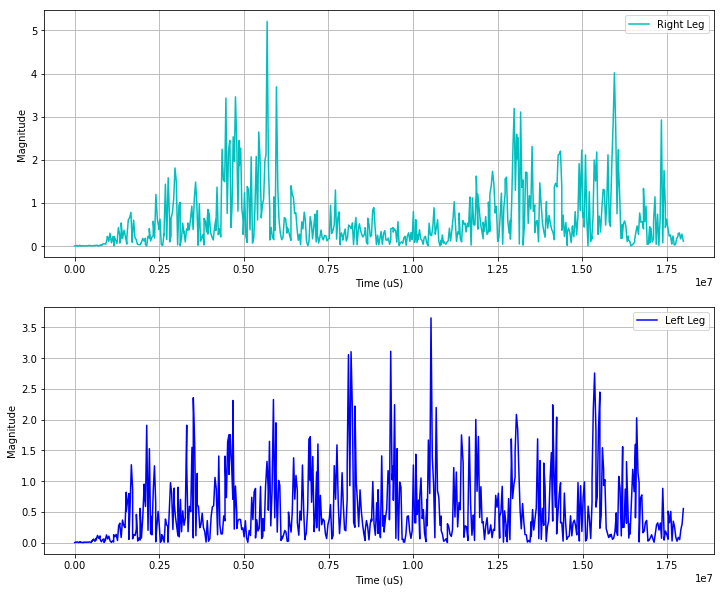

0.832957289813
Average CC:  0.946147190152


In [228]:
from scipy.signal import correlate
from scipy.interpolate import interp1d
import scipy.spatial.distance as ssd
import math

def activity_integrity(ac1, t1, ac2, t2, window_size):
    ac_range = max(len(ac1), len(ac2));
    rcs = [];
    div = 1;
    # delta time array to match xcorr
    for i in range(0, ac_range-window_size, window_size):
        xcorr = correlation(ac1[i:i+window_size],time1[i:i+window_size],ac2[i:i+window_size],time2[i:i+window_size]);
        rcs.append(xcorr);
    return np.mean(rcs)


def correlation(ac1, time1, ac2, time2):
    f = interp1d(ac1, time1)
    f2 = interp1d(ac2, time2)
    
    points = (max(len(ac1), len(ac2)));

    xnew = np.linspace ( min(ac1), max(ac1), num = points) 
    xnew2 = np.linspace ( min(ac2), max(ac2), num = points)
    
    ynew = f(xnew) 
    ynew2 = f2(xnew2) 
    
    return ssd.correlation(ynew, ynew2)

activityRP = np.where((RPTime > 22000000) & (RPTime < 40000000));
activityLP = np.where((LPTime > 22000000) & (LPTime < 40000000));

activity1 = RPMag[activityRP];
time1 = RPTime[activityRP];
time1 = time1 - time1[0];

activity2 = LPMag[activityLP];
time2 = LPTime[activityLP];
time2 = time2 - time2[0];

fig, (ax1, ax2) = plt.subplots(nrows=2);

ax1.plot(time1, abs(activity1), 'c', label="Right Leg");
ax1.legend();
ax1.set_xlabel("Time (uS)")
ax1.set_ylabel("Magnitude");
ax1.grid();

ax2.plot(time2, abs(activity2), 'b', label="Left Leg");
ax2.legend();
ax2.set_xlabel("Time (uS)")
ax2.set_ylabel("Magnitude");
ax2.grid();
plt.show();

# Sampling rate
SRATE = 50;

# Compute cross correlation between every two events found
# NOTE: The number of events on node i and node j MUST be the same

# delta time array to match xcorr
nsamples = max(len(activity1), len(activity2));

ac1mag = activity1;
ac2mag = activity2;

# regularize datasets by subtracting mean and dividing by s.d.
ac1mag -= activity1.mean();
ac1mag /= activity1.std();

ac2mag -= activity2.mean();
ac2mag /= activity2.std();

print(correlation(activity1, time1, activity2, time2))
print("Average CC: ", activity_integrity(ac1mag, time1, ac2mag, time2, 20));

# Find X-Correlation of the anharmonic signals
#xcorr = correlate(ac1mag,ac2mag);

# delta time array to match xcorr
#t = np.asarray(time1);
#dt = np.linspace(-t[-1], t[-1], 2*nsamples-1)
#recovered_sample_shift = dt[xcorr.argmax()]

#dt = np.arange(1-nsamples, nsamples);
#recovered_sample_shift = dt[xcorr.argmax()];
#offset = abs(recovered_sample_shift * SRATE);

#print ("Recovered offset: ", recovered_sample_shift, " samples, or " , offset, " microseconds for 100Hz sample rate");
